### Daytum +2 Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Support Vector Machines Demonstration and Exercise

#### Goal

Facies classification with support vector machines.

#### Description

Here's a simple, documented workflow, demonstration of support vector machines for facies classification for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to to assist with facies assignment from multiple features. 

#### Support Vector Machines

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of support vector machines.

**Prediction**

* estimate a function $\hat{f}$ such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

**Suppervised learning**

* the response feature label, $Y$, is available over the training and testing data

**Unsupervised learning**

* is avaiable with **suport vector clustering** 
    
**Binary separator**

* given the data within a mD feature space, $X_1,\ldots,X_m$, find that boundary maximizes the gap between the two categories

* new cases are classified based on where they fall relative to this boundary 

**Linear and Non-linear**

* **maximum margin classfier**, assignment of a m-1 dimensional hyperplane that maximizes the gap (margin) between the two categories

* **mapped to a higher dimensional space** based on a kernel function, e.g. polygonal and gaussian radial basis function shown below 

##### Applications to subsurface modeling

Support the segmentation of facies categories from a combination of features (porosity, permeability, acoustic impedance etc.). 

* we work with just 2 predictor features for the example below for easy visualization

* flexibility through selection of kernel (hyperparameter) and associated kernel and cost parameters 

#### Workflow Goals

Learn the basics of support vector machine in python to segment facies given petrophysical properties. This includes:

* Loading and visualizing sample data
* Trying out support vector machine with different kernels (linear, polynomial, Gaussian radial basis function)
* Tuning the SVM model parameters and results evaluation  

In [1]:
import numpy as np                                          # arrays and matrix math
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # for plotting
import seaborn as sns                                       # for data visualization
from intake import cat
from sklearn.svm import SVC                                 # support vector machine methods
from sklearn.model_selection import train_test_split        # training and testing datasets
from sklearn.metrics import confusion_matrix                # for sumarizing model performance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()

#### Declare Functions 

Here's a couple of functions that we will use in our workflow to support visualization of the model results.

In [2]:
def visualize_model(model,nxfeature,nyfeature,xfeature,yfeature,response):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 500.0 
    x_min, x_max = min(nxfeature), max(nxfeature) 
    y_min, y_max = min(nyfeature) , max(nyfeature) 
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, plot_step),
                     np.linspace(y_min, y_max, plot_step))
    
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    trans = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    trans_x = trans[:,0].reshape(xx.shape)
    trans_y = trans[:,1].reshape(xx.shape)
    cs = plt.contourf(trans_x, trans_y, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)
    
def plot_svc_decision_function(model,plt, plot_support=True): # modified from Jake VanderPlas's Python Data Science Handbook  
    """Plot the decision function for a 2D SVC"""
    xlim = [-2.5,2.5]
    ylim = [-2.5,2.5]
    # plot support vectors
    sv = scaler.inverse_transform(model.support_vectors_)
    if plot_support:
        plt.scatter(sv[:, 0],
                   sv[:, 1],
                   s=3, linewidth=8,alpha = 0.6, facecolors='black');

#### Loading Data
Let's load the provided multivariate, spatial data source `sample_data_12`.  It is a comma delimited file with: 

* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 

In [3]:
df = cat.sample_data_12.read()                      # read a .csv file in as a DataFrame

* Let's get a quick preview of our new DataFrame, 'df' with the built in function.

```python
df.head()
```

In [4]:
df.head(n=13)

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,1,50.0,900.0,1.0,0.220761,140.021266,3413.063944
1,2,50.0,850.0,1.0,0.237154,39.837129,3074.562617
2,3,50.0,800.0,1.0,0.234352,84.992437,2292.783358
3,4,50.0,750.0,1.0,0.244553,90.632307,2494.848885
4,5,50.0,700.0,1.0,0.231787,811.547979,2522.063995
5,6,50.0,650.0,1.0,0.233280,426.992456,3964.185956
6,8,50.0,550.0,1.0,0.234423,2398.406492,3318.885844
7,9,50.0,500.0,1.0,0.219657,1637.224971,3030.874323
8,10,50.0,450.0,1.0,0.200389,265.636019,3454.389302
9,12,50.0,350.0,0.0,0.165908,7.951511,5025.286221


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,480.0,402.064583,248.064403,1.000000,170.500000,412.000000,620.500000,826.000000
X,480.0,430.187500,263.832692,0.000000,200.000000,390.000000,630.000000,980.000000
Y,480.0,522.166667,284.293420,19.000000,279.000000,539.000000,759.000000,999.000000
Facies,480.0,0.616667,0.486706,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,480.0,0.189440,0.031702,0.117562,0.165884,0.185443,0.216513,0.261091
Perm,480.0,520.932093,1226.207190,0.005776,6.539988,49.451463,369.470756,10319.904849
AI,480.0,3758.879653,779.990582,1746.387548,3212.900121,3719.883000,4236.160395,6194.573653


#### Visualization of Loaded Data

In this excises, we want to use support vector machine to help segment, classify, facies based on acoustic impedance and porosity predictor features. 

First we need to visualize the dataframe we loaded.  

* We will use the Seabon package has built-in function ```scatterplot ``` to do scatter plot with categorical data like facies.

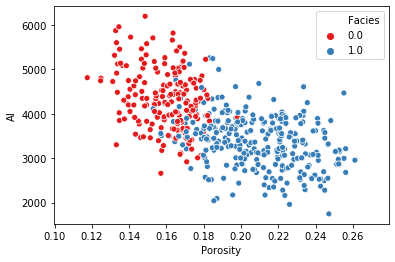

In [6]:
sns.scatterplot(x = 'Porosity', y = 'AI', hue='Facies',data=df,legend='full',palette = "Set1")

Segmentation looks possible, but it will not be easy as there is a lot of overlap. 

#### Split Training and Testing Data

As a supervised learning classifier, support vector machine requires:

* **training data** to train the model parameters

* **testing data** to check the model performance and tune the hyperparameters. 

First we split loaded data into training (70%) and testing data (30%) randomly using a function from sklean 

```python
train, test = train_test_split()
```

The function parameters include:

* **df** - the data frame
* **random_state** - the random number seed for reproducibility
* **test_size** - the fraction of the data withheld for the testing data set

In [7]:
train, test = train_test_split(df,random_state=4, test_size=0.3)

Check the training and testing set to see if split fairly.

* not too few data
* not extremely clustered
* limited extrapolation from training to testing

Of course, there is a lot of complexity related to a 'fair' testing dataset. We will not get into this now.

Here's the training dataset.

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,336.0,410.988095,250.346422,1.000000,175.750000,425.000000,636.250000,825.000000
X,336.0,414.851190,259.318237,0.000000,200.000000,380.000000,600.000000,980.000000
Y,336.0,518.910714,286.397789,19.000000,274.000000,519.000000,771.500000,999.000000
Facies,336.0,0.642857,0.479872,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,336.0,0.190476,0.031140,0.117562,0.166488,0.185941,0.217709,0.261091
Perm,336.0,471.161972,1145.187632,0.005776,7.064275,58.725397,347.354395,10319.904849
AI,336.0,3735.059482,792.252806,1961.600397,3174.747295,3713.243725,4205.162960,6194.573653


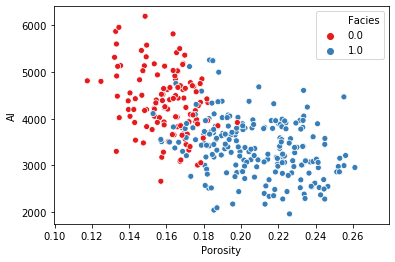

In [8]:
### plots the training data set
sns.scatterplot(x = 'Porosity', y = 'AI', hue='Facies',data=train,legend='full',palette = "Set1")
train.describe().transpose()

and here is the testing dataset.

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,144.0,381.243056,242.235632,8.000000,163.250000,366.000000,602.500000,826.000000
X,144.0,465.972222,271.634059,10.000000,250.000000,400.000000,700.000000,980.000000
Y,144.0,529.763889,280.163364,19.000000,289.000000,550.000000,750.000000,989.000000
Facies,144.0,0.555556,0.498638,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.187022,0.032958,0.124696,0.162600,0.181415,0.213573,0.256172
Perm,144.0,637.062376,1394.557679,0.011516,5.074369,34.756208,442.638799,8961.824747
AI,144.0,3814.460053,750.354058,1746.387548,3342.086271,3761.836229,4273.471868,5725.525232


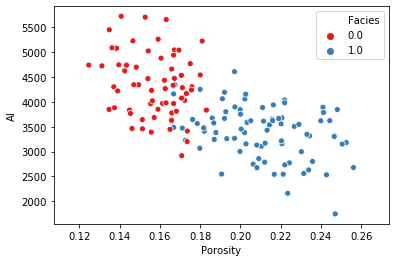

In [9]:
###Testing data set
sns.scatterplot(x = 'Porosity', y = 'AI', hue='Facies',data=test,legend='full',palette = "Set1")

test.describe().transpose()

We need to reformat our data to inputs to train the support vector machine. 

* we extract the features (Acoustic impedance and Porosity) into a $n \times 2$ array and the cateogrical response (facies) into a separate $n \times 1$ array 

where $n$ is the number of data samples

We will show the first 10 samples to check our reformatting.

In [10]:
train_X = train.loc[:,['Porosity','AI']]
train_X = train_X.reset_index(drop = True)

train_y = train['Facies']
train_y = train_y.reset_index(drop = True)
print('The training predictor features:')
print(train_X.head())
print('\nThe training response features:')
print(train_y.head())

The training predictor features:
   Porosity           AI
0  0.204313  4373.187870
1  0.228370  2975.483280
2  0.166260  5016.841662
3  0.237154  3074.562617
4  0.233895  2386.160099

The training response features:
0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: Facies, dtype: float64


SVMs assume that the data it works with is in a standard range, usually -1 to 1 (roughly). So we need to normalize the features prior to fit them to the SVM. Otherwise one feature would be scaled more important than the other and will skew the results.

We will transfor the normalized data back when visualize the result.

In [11]:
scaler = StandardScaler()
xx = scaler.fit_transform(train_X)
train_X['nPorosity'] = xx[:,0]
train_X['nAI'] = xx[:,1]
train_X.head()

,Porosity,AI,nPorosity,nAI
0,0.204313,4373.187870,0.445012,0.806662
1,0.228370,2975.483280,1.218698,-0.960185
2,0.166260,5016.841662,-0.778816,1.620308
3,0.237154,3074.562617,1.501206,-0.834938
4,0.233895,2386.160099,1.396390,-1.705152


#### Support Vector Machine Model with Linear Kernel

Let's train and plot linear support vector machine models over our solution space. 

* This will provide a linear spatial classification model for facies 0 and 1 as a function of AI and porosity.

We use the scikit-learn function $SVC$ substantiate the support vector machine:

```python
svm_linear = SVC()
```

The parameters include:

* **kernel** the kernel type that is applied to project the data to a potentially higher dimensional space
* **C** penalty for misclassification
* **random_state** random number see for random shuffling data for probability estimates

We then use the command"

```python
svm_linear.fit()
```
to train the model with the training dataset.

The parameters include:

* **X** - the $n \times m$ array with the predictor features for the training dataset 
* **y** - the $n \times 1$ array with the response feature for the training dataset 

We will also 

In [12]:
C = 0.1
svm_linear = SVC(kernel = 'linear',C = C, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear.fit(train_X.loc[:,['nPorosity','nAI']], train_y)    # Train the classifier

C = 10
svm_linear = SVC(kernel = 'linear',C = C, random_state = 0)    # Create a SVC classifier using a linear kernel
svm_linear.fit(train_X.loc[:,['nPorosity','nAI']], train_y)    # Train the classifier

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

Looks like it ran ok!  Let's visualize the results using the convenient visualization functions that we previously defined. 

/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


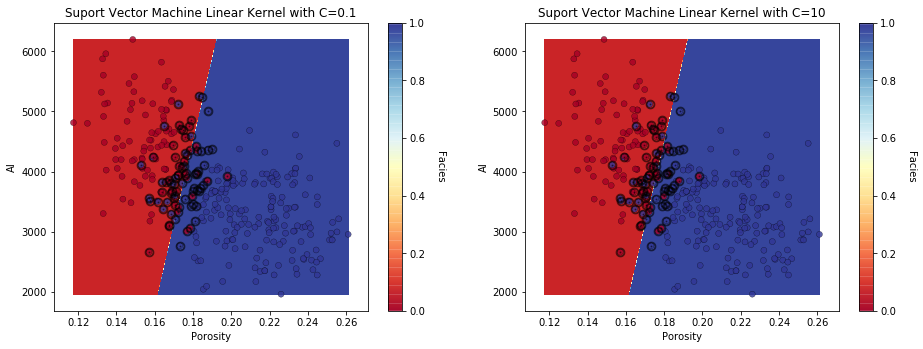

In [13]:
plt.subplot(121)
plt = visualize_model(svm_linear,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plot_svc_decision_function(svm_linear,plt,plot_support=True)
plt.title('Suport Vector Machine Linear Kernel with C=0.1')

plt.subplot(122)
plt = visualize_model(svm_linear,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plot_svc_decision_function(svm_linear,plt,plot_support=True)
plt.title('Suport Vector Machine Linear Kernel with C=10')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

The above plot shows the linear kernel support vector machine classification model (Facies 0 is red and facies 1 is blue), the training dataset and the resulting support vectors circled. 

* Linear kernel only provide a straight decision boundary. 

* It is hard to tune the model to fit more complicated situation.

Let's try some more flexible classifiers with a different kernel.Recall, there is a trade off:

* more complexity reduces model bias (error due to a simple model not fitting the actual data)
* but increases model variance (sensitivity to training data).

#### Support Vector Machine Model with Polynomial Kernel

The polynomial kernel is defined as

\begin{equation}
K(x,x') = (x^Tx)^d,
\end{equation}

where $d$ is the degree of polynomials.

While using the SVC function in scikit-learn package,```C```is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is smaller, the classifier is more tolerant with misclassified data points (high bias, low variance). 

```Degree``` is to control the order of the polynomial kernel function. 

In [14]:
C = 1
svm_poly3_C1 = SVC(kernel = 'poly', degree = 3, random_state=0,C = C)
svm_poly3_C1.fit(train_X.loc[:,['nPorosity','nAI']],train_y) 

C = 1
svm_poly4_C1 = SVC(kernel = 'poly', degree = 4,random_state=0, C = C)
svm_poly4_C1.fit(train_X.loc[:,['nPorosity','nAI']],train_y) 

C = 100
svm_poly3_C100 = SVC(kernel = 'poly', degree = 3,random_state=0, C = C)
svm_poly3_C100.fit(train_X.loc[:,['nPorosity','nAI']],train_y) 

C = 100
svm_poly4_C100 = SVC(kernel = 'poly', degree = 4, random_state=0, C = C)
svm_poly4_C100.fit(train_X.loc[:,['nPorosity','nAI']],train_y) 

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

Looks like it ran again!  Let's visualize the results again with our plotting function.

/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/m

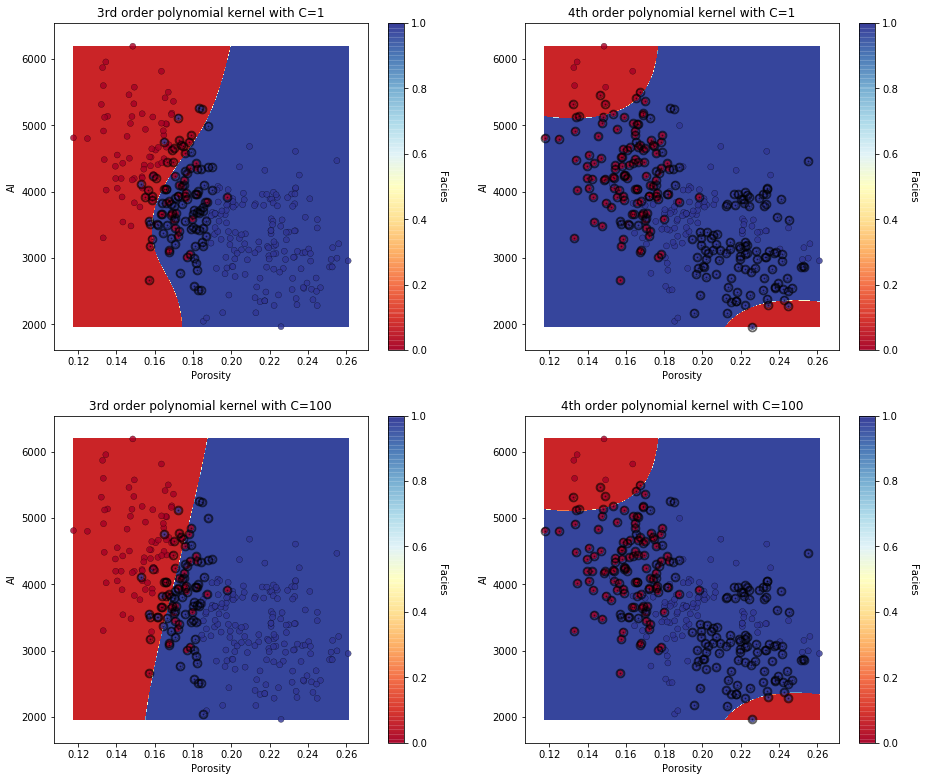

In [15]:
plt.subplot(221)
plt = visualize_model(svm_poly3_C1,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('3rd order polynomial kernel with C=1')
plot_svc_decision_function(svm_poly3_C1,plt, plot_support=True)

plt.subplot(222)
plt = visualize_model(svm_poly4_C1,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('4th order polynomial kernel with C=1')
plot_svc_decision_function(svm_poly4_C1,plt, plot_support=True)

plt.subplot(223)
plt = visualize_model(svm_poly3_C100,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('3rd order polynomial kernel with C=100')
plot_svc_decision_function(svm_poly3_C100,plt, plot_support=True)

plt.subplot(224)
plt = visualize_model(svm_poly4_C100,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('4th order polynomial kernel with C=100')
plot_svc_decision_function(svm_poly4_C100,plt, plot_support=True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)

The 3rd order polynomial kernal performs quite well.  With a low $C$, penalty parameter, we see more local fit, while the high penatly parameter result in a less specific fit.  

The 4th order and higher order polynomial does not perform well.

#### Support Vector Machine Model with Radial Basis Function Kernel

Radial Basis Function (RBF) is another commonly used kernel in SVC:

\begin{equation}
K(x,x') = e^{- \gamma ||x-x'||^2},
\end{equation}

where $||x-x'||^2$ is the squared Euclidean distance between two data points x and x'. 

Gaussian kernel is a special case of RBF, where: 

\begin{equation}
K(x,x') = e^{- \frac {||x-x'||^2} {2 \sigma^2}}.
\end{equation}

By changing the value of $\gamma$ and C, the classifier with an RBF kernel can be tuned.

$\gamma$ can be thought of as the spread of the kernel. 

* When $\gamma$ is low, the curve of the decision boundary is low and lead to a broad decision region (low variance, high bias)

* The $\gamma$ parameter can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/m

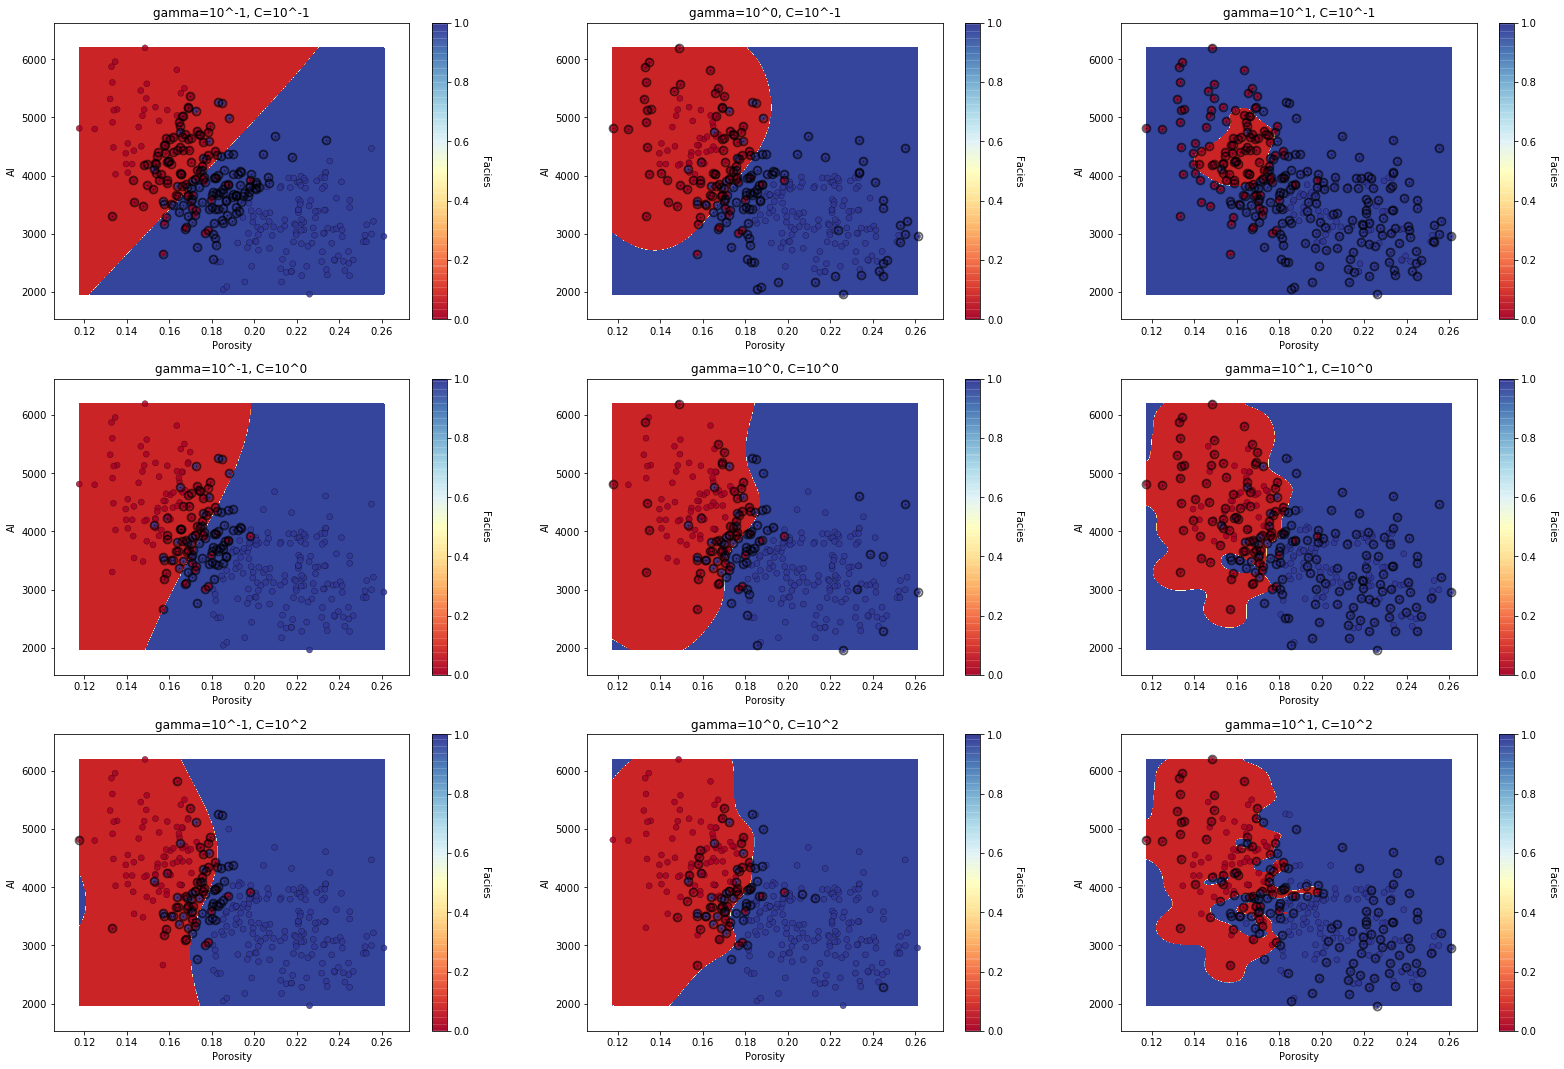

In [16]:
C_2d_range = [1e-1, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(kernel = 'rbf',C=C, gamma=gamma)
        clf.fit(train_X.loc[:,['nPorosity','nAI']], train_y)
        classifiers.append((C, gamma, clf))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt = visualize_model(clf,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
    plot_svc_decision_function(clf,plt,plot_support=True)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)))
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=3.5, wspace=0.2, hspace=0.2)

Although two facies seem to be classified properly in some cases above, there is a risk of overfitting. 

#### Evaluating Performance Over Multiple Parameters

Now we try to evaluate the result and find the proper parameter values for all the dataset. 

* Draw heatmap of the cross-validation accuracy as a function of gamma and C. 

* The higher score indicates better testing performance

First we must normalize all of the data.

In [17]:
xx = scaler.fit_transform(df.loc[:,['Porosity','AI']])  ### normalize all the data
df['nPorosity'] = xx[:,0]
df['nAI'] = xx[:,1]
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,nPorosity,nAI
0,1,50.0,900.0,1.0,0.220761,140.021266,3413.063944,0.989042,-0.443821
1,2,50.0,850.0,1.0,0.237154,39.837129,3074.562617,1.506684,-0.878255
2,3,50.0,800.0,1.0,0.234352,84.992437,2292.783358,1.418176,-1.881594
3,4,50.0,750.0,1.0,0.244553,90.632307,2494.848885,1.740311,-1.622263
4,5,50.0,700.0,1.0,0.231787,811.547979,2522.063995,1.337183,-1.587335


Now we will iterative over multiple parameter cases.  

* Part of the code was modified from scikit-learn RBF SVM parameter example
* This Loop will take a while to run

In [18]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=4)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(df.loc[:,['nPorosity','nAI']], df['Facies'])
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

Now we can visualize the cross validation accuracy for all of the parameter combinations.

Text(0.5, 1.0, 'Validation accuracy')

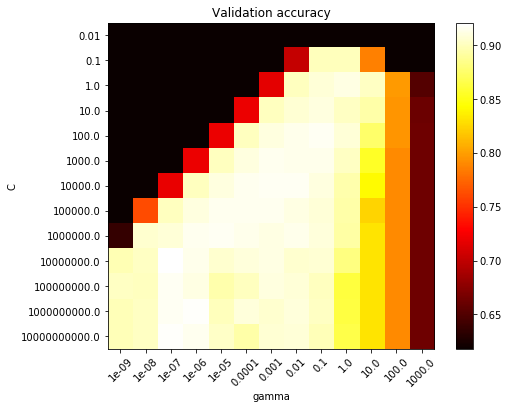

In [19]:
plt.figure(figsize=(8, 6))    
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')

#### Visualizing High, Mid and Low Performing Models

Now we show examples of high, mid and low performing model based on validation accuracy from the demonstration above.

* we will use parameter combinations, $C$ and $\gamma$, from the plot above to select and rerun the cases.

In [20]:
C=1e6;gamma=0.01                                                # High
clf_c0_g01 = SVC(kernel = 'rbf',C=C, gamma=gamma)
clf_c0_g01.fit(train_X.loc[:,['nPorosity','nAI']], train_y)

C=100;gamma=10                                                  # Mid
clf_c100_g10 = SVC(kernel = 'rbf',C=C, gamma=gamma)
clf_c100_g10.fit(train_X.loc[:,['nPorosity','nAI']], train_y)

C=100;gamma=100                                                 # Low
clf_c100_g100 = SVC(kernel = 'rbf',C=C, gamma=gamma)
clf_c100_g100.fit(train_X.loc[:,['nPorosity','nAI']], train_y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now let's visualize the low, mid and high performing support vector machine classification models for our facies assignment.

/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/john/miniconda3/envs/daytum3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/john/m

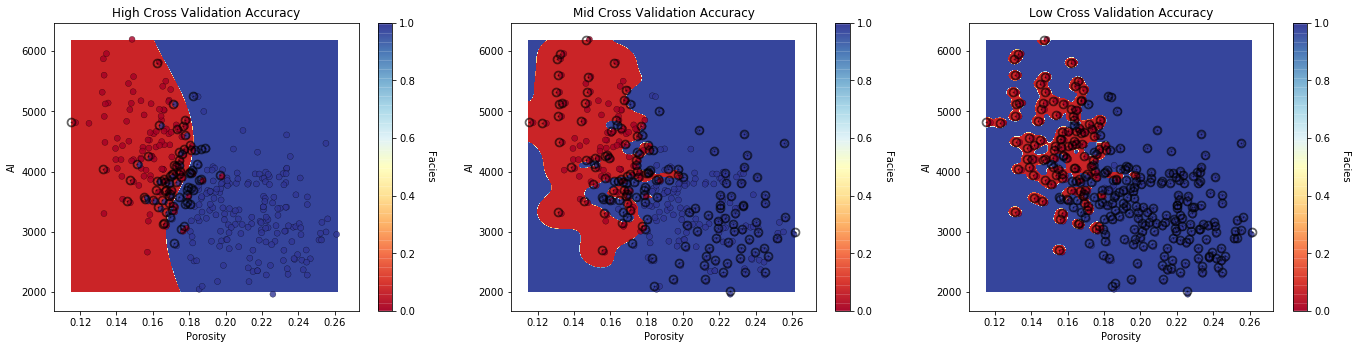

In [21]:
plt.subplot(131)
plt = visualize_model(clf_c0_g01,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('High Cross Validation Accuracy')
plot_svc_decision_function(clf_c0_g01,plt, plot_support=True)

plt.subplot(132)
plt = visualize_model(clf_c100_g10,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('Mid Cross Validation Accuracy')
plot_svc_decision_function(clf_c100_g10,plt, plot_support=True)

plt.subplot(133)
plt = visualize_model(clf_c100_g100,train_X["nPorosity"],train_X["nAI"],train_X["Porosity"],train_X["AI"],train_y)
plt.title('Low Cross Validation Accuracy')
plot_svc_decision_function(clf_c100_g100,plt, plot_support=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=1, wspace=0.2, hspace=0.2)

### Summary 

Here's some observations from this workflow.

* Linear kernel only works for linear decision boundary problems while polynomial and RBF kernels perform better for more complicated boundaries.

* By tuning parameters like C and $\gamma$, it is possible to use RBF model to segment facies with a good bias-variance trade-off. 

* SVM does not work well when there is overlap among each category and it is sensitive to outliers.

* Computationally intensive when there are a lot of data.

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>